In [2]:
from Bio import Phylo

In [8]:
import pickle
import numpy as np
import pandas as pd

In [16]:
from tqdm import tqdm

In [9]:
def mut_freq(mt_muts, max_mut_id = None, sel_cells=None):
    if not max_mut_id:
        max_mut_id = np.max([np.max(list(j)) for j in mt_muts[i.name] if j for i in mt_muts])
    max_mut_id += 1
    mut_freqs = []
    cell_names = []
    for cell in tqdm(sel_cells):
        mut_pos = np.zeros((len(mt_muts[cell]), max_mut_id))
        for ind, mt in enumerate(mt_muts[cell]):
            mut_pos[ind][list(mt)] = 1
        mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))
        cell_names.append(cell)
    mf = pd.DataFrame(mut_freqs, index=cell_names)
    mf = mf[mf.columns[mf.sum()>0]]
    return mf

In [131]:
tree = Phylo.read('/data3/wangkun/mtsim_res/res_1113/630531/linear_tree_gt_630531.nwk', format='newick')

In [167]:
sel_cells = [i.name for i in tree.get_terminals()]

In [168]:
tree_origin = pd.read_csv('/data3/wangkun/mtsim_res/res_1113/630531/tree_origin_linear_630531.csv')

In [169]:
tree_origin['cell_name'] = tree_origin.apply(lambda x: f"<{int(x['generation'])}_{int(x['cell_id'])}>", axis=1)

In [170]:
tree_origin.index = tree_origin.cell_name

In [171]:
cell_types = tree_origin.loc[sel_cells]['state'].to_numpy().flatten()

In [166]:
mt = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/630531/mt_allmuts_mid_0.1_630531.pkl', 'rb'))

In [172]:
mutation_count = []
mutation_type = []
for cell in sel_cells:
    mutation_count.append(len(sum([list(i) for i in mt[cell]], [])))
    mutation_type.append(len(set(sum([list(i) for i in mt[cell]], []))))
mutation_count = np.array(mutation_count)
mutation_type = np.array(mutation_type)

<Axes: >

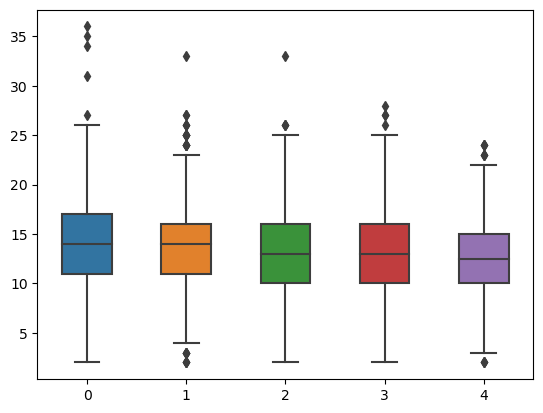

In [219]:
sns.boxplot([mutation_type[cell_types==i] for i in range(5)], width=0.5)

In [173]:
import seaborn as sns

In [188]:
cell_generation = np.array([int(i.split('_')[0][1:]) for i in sel_cells])

Text(0, 0.5, 'cell generation')

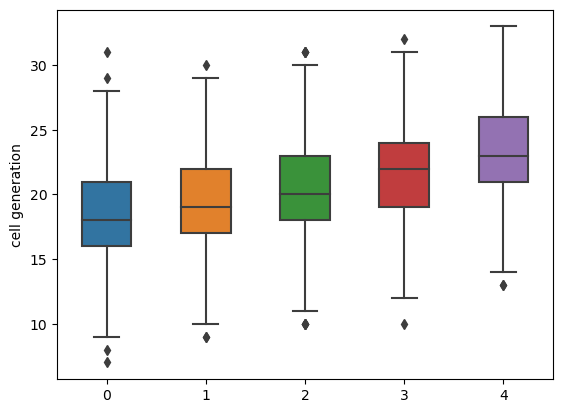

In [192]:
sns.boxplot([cell_generation[cell_types==i] for i in range(5)], width=0.5)
plt.ylabel('cell generation')

Text(0, 0.5, 'mutation type')

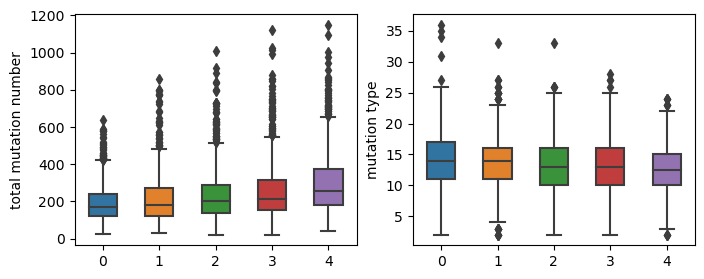

In [183]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.boxplot([mutation_count[cell_types==i] for i in range(5)],ax=ax[0], width=0.5)
ax[0].set_ylabel('total mutation number')
sns.boxplot([mutation_type[cell_types==i] for i in range(5)], width=0.5)
ax[1].set_ylabel('mutation type')
ax[0].set_xlabel('cell_type')
ax[1].set_xlabel('cell_type')
fig.suptitle('')

In [215]:
mutations = np.array([0,0,0,0,1,1,2,3])

In [216]:
division = np.random.binomial(1, 0.5, 8)

In [217]:
mutations[division==1]

array([0, 0, 1, 1, 3])

In [218]:
mutations[division==0]

array([0, 0, 2])

In [21]:
import matplotlib.pyplot as plt

100%|██████████| 1/1 [00:00<00:00, 280.52it/s]


(array([88., 10.,  1.,  2.,  2.,  0.,  0.,  0.,  1.,  1.]),
 array([0.002 , 0.0116, 0.0212, 0.0308, 0.0404, 0.05  , 0.0596, 0.0692,
        0.0788, 0.0884, 0.098 ]),
 <BarContainer object of 10 artists>)

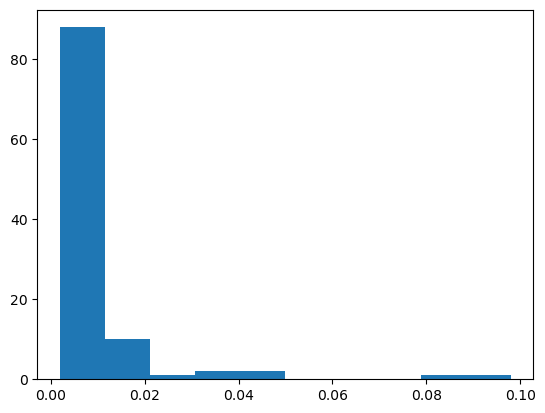

In [26]:
plt.hist(mut_freq(mt, max([np.max(list(i)) for i in mt['<0_0>'] if len(i)>0]), ['<0_0>']).to_numpy()[0])

In [80]:
from collections import Counter
def specific_mutation(cell, cell_group, mts, cutoff=0):
    # specific_mutation('<3_0>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)
    if cell in cell_group:
        cell_group.remove(cell)
    if cutoff:
        cnt = Counter(sum([list(i) for i in mt[cell]], []))
        muts = np.array(list(cnt.keys()))[np.array(list(cnt.values()))>cutoff]
        group_muts = set()
        for j in cell_group:
            cnt = Counter(sum([list(i) for i in mt[j]], []))
            jmuts = np.array(list(cnt.keys()))[np.array(list(cnt.values()))>cutoff]
            group_muts = group_muts.union(set(jmuts))
    else:
        muts = set(sum([list(i) for i in mt[cell]], []))
        group_muts = set(sum([sum([list(i) for i in mt[j]], []) for j in cell_group], []))
    muts, group_muts = list(muts), list(group_muts)
    return np.array(muts)[~np.isin(muts, group_muts)]

In [130]:
def ancestor_tracing(cells, ancestors, tree, count=True):
    ancestors = [tree.find_any(i) for i in ancestors]
    res = np.array([None]*len(cells))
    for anc in ancestors:
        res[np.isin(cells, [i.name for i in anc.get_terminals()])] = anc.name
    if count:
        return Counter(res)
    else:
        return res

In [129]:
cells = np.array([i.name for i in tree.get_terminals()])
cells = cells[np.random.choice(range(1000), 10, replace=False)]
ancestor_tracing(cells, [i for i in mt.keys() if i[1:3]=='3_'], tree)

Counter({'<3_0>': 9, '<3_1>': 1})

In [127]:
cells

array(['<19_1015>', '<25_1878>', '<25_586>', '<15_3422>', '<22_2200>',
       '<19_5556>', '<14_2709>', '<20_4424>', '<28_345>', '<23_2846>'],
      dtype='<U9')

In [93]:
specific_mutation('<3_1>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)

array([  2,  27,  60,  82,  97, 104])

In [95]:
specific_mutation('<3_3>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)

array([62, 68])

In [96]:
specific_mutation('<3_4>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)

array([ 34,  35,  54,  67, 103, 117])

In [97]:
specific_mutation('<3_5>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)

array([ 47,  94, 106, 114])

In [98]:
specific_mutation('<3_6>', [i for i in mt.keys() if i[1:3]=='3_'], mt, cutoff=0)

array([15, 29, 44])

In [226]:
tree.get_terminals()[0].name

'<23_2939>'

In [227]:
mt[tree.get_terminals()[3].name]

[{0, 26},
 {0, 26},
 {0, 26},
 {0, 26},
 {0, 26},
 {0, 26},
 {0, 26},
 {0, 5, 32},
 {0, 5, 32},
 {0, 5, 32},
 {0, 5, 32},
 {0, 5, 32},
 {0, 5, 32},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0, 10},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 38},
 {0, 6, 30},
 {0, 4},
 {0, 4},
 {0

In [306]:
from copy import deepcopy
def cell_division_with_mt1(mt_muts, global_mutid, mut_rate, mt_copynumber=2):
    new_mts = []
    if mt_copynumber == 2:
        new_mts = mt_muts*2
    elif mt_copynumber > 2:
        new_mts = mt_muts*2
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-2)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
    else:
        new_mts = mt_muts
        n_mts = len(mt_muts)
        addi = np.random.choice(range(n_mts), int(n_mts*(mt_copynumber-2)), replace=False)
        new_mts = new_mts + list(np.array(mt_muts)[addi])
        
    division = np.random.binomial(1, 0.5, len(new_mts)).astype(bool)
    if np.sum(division) < 100:
        division = ~division
    cell1 = np.array(new_mts)[division]
    cell2 = np.array(new_mts)[~division]
    return list(cell1), list(cell2), global_mutid

In [268]:
tree = Phylo.read('/data3/wangkun/mtsim_res/res_1113/636286/linear_tree_gt_636286.nwk', format='newick')
tree_origin = pd.read_csv('/data3/wangkun/mtsim_res/res_1113/636286/tree_origin_linear_636286.csv')
mt = pickle.load(open('/data3/wangkun/mtsim_res/res_1113/636286/mt_allmuts_early_1_636286.pkl', 'rb'))

In [315]:
new_mts_300 = dict()
new_mts_600 = dict()
new_mts_800 = dict()
for cell in tqdm(tree.get_terminals()):
    new_mts_300[cell.name] = mt[cell.name]
    # cell_gen = int(cell.name.split('_')[0][1:])
    for _ in range(12):
        new_mts_300[cell.name] = cell_division_with_mt1(new_mts_300[cell.name],0,0,2.2)[0]
    for _ in range(290):
        new_mts_300[cell.name] = cell_division_with_mt1(new_mts_300[cell.name],0,0)[0]
    new_mts_600[cell.name] = new_mts_300[cell.name]
    for _ in range(300):
        new_mts_600[cell.name] = cell_division_with_mt1(new_mts_600[cell.name],0,0)[0]
    new_mts_800[cell.name] = new_mts_600[cell.name]
    for _ in range(200):
        new_mts_800[cell.name] = cell_division_with_mt1(new_mts_800[cell.name],0,0)[0]

100%|██████████| 5000/5000 [14:38<00:00,  5.69it/s]


In [316]:
np.mean([len(new_mts_800[i]) for i in new_mts_800])

593.441

In [317]:
np.mean([len(new_mts_600[i]) for i in new_mts_800])

574.8862

In [318]:
np.mean([len(new_mts_300[i]) for i in new_mts_800])

542.9878

In [363]:
file = open("/data3/wangkun/mtsim_res/res_1113/bifurcated/552569/mt_allmuts_mid_0.1_552569_300.pkl", "rb")
data = pickle.load(file)

In [364]:
def mut_freq(mt_muts, max_mut_id = None, sel_cells=None):
    if sel_cells is None:
        sel_cells = list(mt_muts.keys())
    if not max_mut_id:
        max_mut_id = max([max([max(list(i)+[0]) for i in mt_muts[j]]+[0]) for j in sel_cells])
    max_mut_id += 1
    mut_freqs = []
    cell_names = []
    for cell in tqdm(sel_cells):
        mut_pos = np.zeros((len(mt_muts[cell]), max_mut_id))
        for ind, mt in enumerate(mt_muts[cell]):
            mut_pos[ind][list(mt)] = 1
        mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))
        cell_names.append(cell)
    mf = pd.DataFrame(mut_freqs, index=cell_names)
    mf = mf[mf.columns[mf.sum()>0]]
    return mf

In [365]:
data['<12_1289>']

[]

In [366]:
freq = mut_freq(data)

  2%|▏         | 86/5000 [00:00<00:11, 428.57it/s]/tmp/ipykernel_86059/3739064826.py:13: RuntimeWarning: invalid value encountered in divide
  mut_freqs.append(mut_pos.sum(0)/len(mt_muts[cell]))
100%|██████████| 5000/5000 [00:16<00:00, 306.34it/s]


In [355]:
freq

,0,1,2,3,5,6,7,8,9,10,...,5040,5063,5068,5070,5074,5088,5105,5126,5127,5129
<33_75>,0.014599,0.000000,0.985401,0.000000,0.000000,0.0,0.085766,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<30_65>,0.353623,0.000000,0.637681,0.000000,0.000000,0.0,0.200000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<29_35>,0.329146,0.000000,0.630653,0.000000,0.000000,0.0,0.630653,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<29_40>,0.256809,0.000000,0.610895,0.000000,0.000000,0.0,0.344747,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<31_89>,0.132924,0.000000,0.867076,0.000000,0.000000,0.0,0.676892,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
<10_647>,0.000000,0.000000,0.130081,0.000000,0.869919,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<11_413>,0.786848,0.000000,0.000000,0.000000,0.213152,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<15_2768>,0.515464,0.000000,0.484536,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
<14_1936>,0.610656,0.389344,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [357]:
freq.loc['<12_1289>']

KeyError: '<12_1289>'

In [338]:
mt['a'] = [set(), set()]

In [340]:
sel_cells = list(mt.keys())

In [341]:
max([max([max(list(i)+[0]) for i in mt[j]]) for j in sel_cells])

10626